<img src="https://github.com/PKhosravi-CityTech/LightCnnRad/raw/main/Images/BioMindLogo.png" alt="BioMind AI Lab Logo" width="150" height="150" align="left" style="margin-bottom: 40px;"> **Repository Developed by Pegah Khosravi, Principal Investigator of the BioMind AI Lab**

Welcome to this repository! This repository is a result of collaborative efforts from our dedicated team at the lab. We are committed to advancing the field of biomedical AI and pushing the boundaries of medical data analysis. Your interest and contributions to our work are greatly appreciated. For more information about our lab and ongoing projects, please visit the [BioMind AI Lab website](https://sites.google.com/view/biomind-ai-lab). Thank you for your interest and support!

#DepthNet

💠 Depthwise separable convolutions for efficient and scalable image classification.

In the development of the DepthNet neural network architecture, we employed a sophisticated approach utilizing depthwise separable convolutions to create an efficient and effective model for image classification tasks. The architecture consists of four depthwise separable convolution blocks, each comprising a depthwise convolution layer followed by a pointwise convolution layer, which significantly reduces the number of parameters compared to traditional convolutional networks. This design choice not only improves computational efficiency but also reduces overfitting due to the decreased model complexity.

Each block includes batch normalization and ReLU activation functions to stabilize learning and introduce non-linearity, followed by max pooling to reduce spatial dimensions and enhance feature extraction. The network's output from the convolutions is processed through fully connected layers, incorporating a dropout rate of 60% before the final classification layer to prevent overfitting further. This model architecture is tailored to operate efficiently on both CPU and GPU environments, ensuring versatile deployment capabilities. The model initializes with a simple binary classification objective but can be adapted to accommodate more classes as needed. This adaptability makes DepthNet suitable for a wide range of image recognition applications, demonstrating its robustness and scalability in practical scenarios.

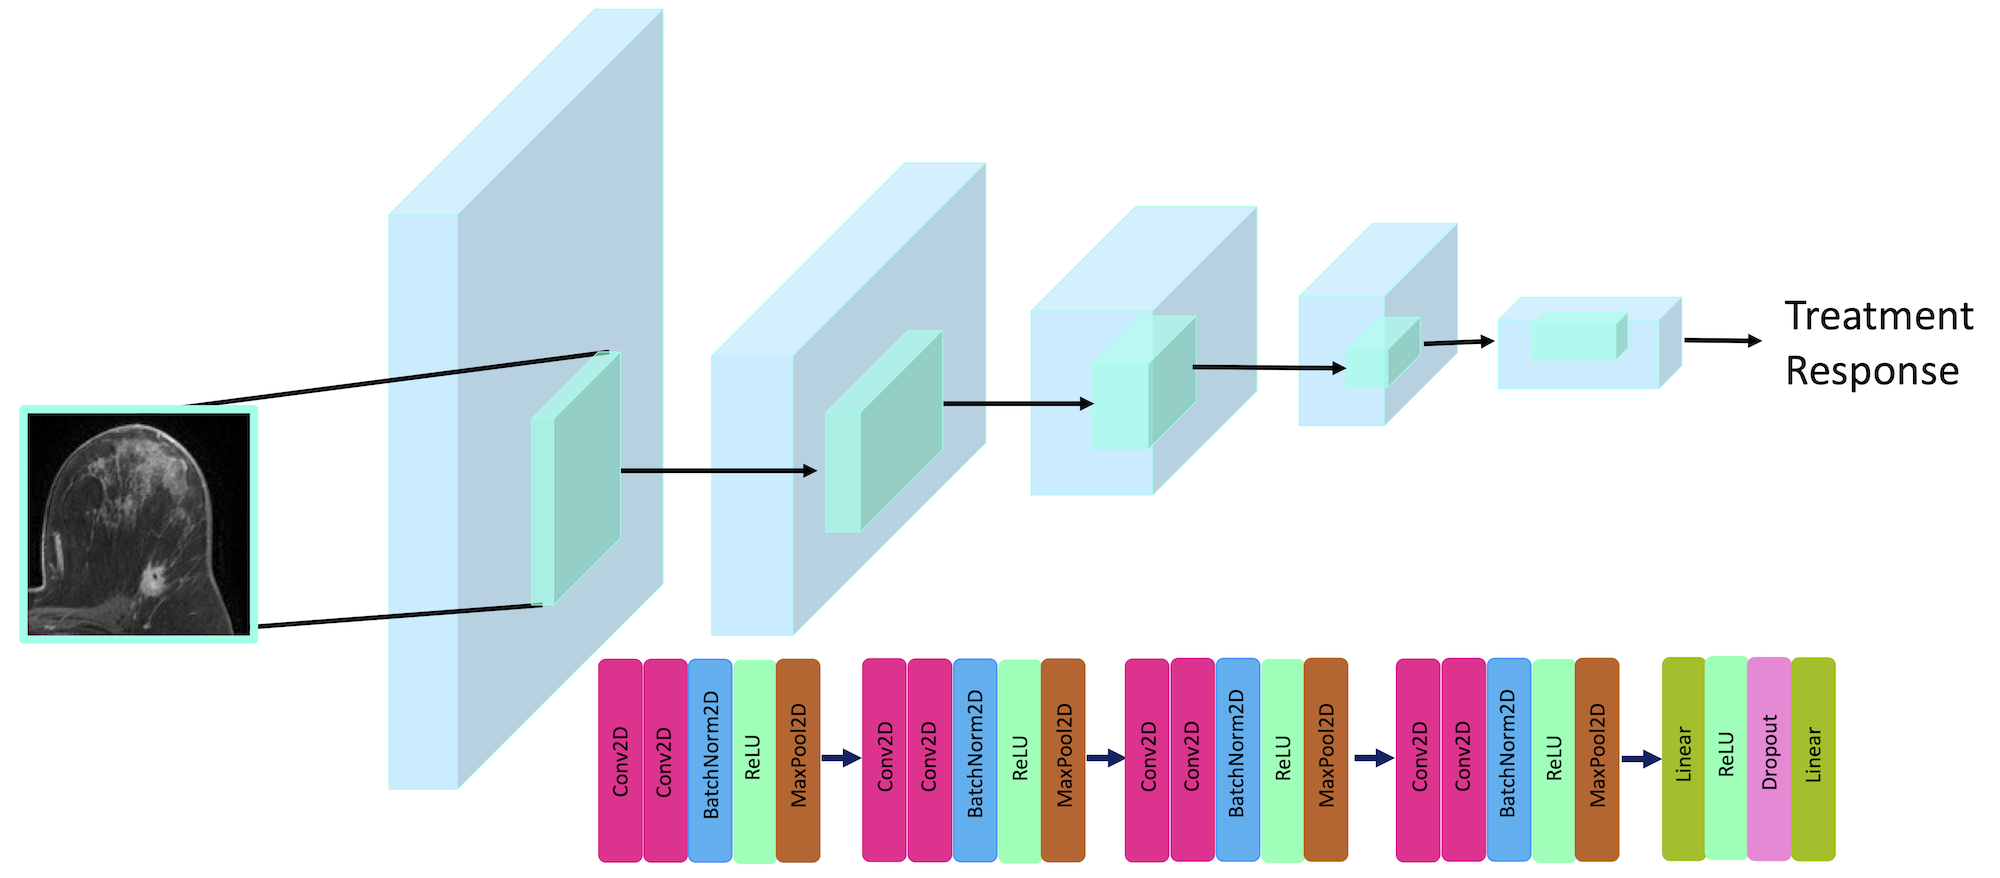

DepthNet Model for Predicting Treatment Response in MRI Images
----------------------------------------------------------------

The DepthNet model is a CNN designed for analyzing high-resolution MRI images (input size 512x512). It features multiple convolutional layers, batch normalization, ReLU activations, and dropout to meticulously extract and analyze image features. Notably, the model classifies images into one of two categories, such as effective or ineffective treatment responses, and measures patient-level accuracy. We utilize early stopping techniques to enhance training efficiency and prevent overfitting, terminating training if there's no improvement in validation accuracy over a set number of epochs.

This script outlines the DepthNet model's implementation using PyTorch, from the architecture's setup to its readiness for both training and evaluation. This ensures the model not only learns effectively but also generalizes well across new, unseen data.


Import all the necessary libraries.

In [1]:
#Load libraries
import os
import numpy as np
import random
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.autograd import Variable
import torchvision
import pathlib
#https://analyticsindiamag.com/ultimate-guide-to-pytorch-optimizers/
from torch.optim.adamw import AdamW
from torch.optim.adamax import Adamax
from torch.optim.sparse_adam import SparseAdam
from torch.optim.sgd import SGD
from torch.optim.adagrad import Adagrad
from torch.optim.rmsprop import RMSprop
import time
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
import torch.optim as optim
import csv
import pathlib
import pandas as pd
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

Checking the availiblity of GPU

In [2]:
torch.cuda.empty_cache()
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


Transforms are applied to the input images to prepare them for the deep learning model. These transformations include resizing the images to 512x512 pixels, randomly flipping them horizontally for data augmentation, converting them to tensors, and normalizing the pixel values to have a mean of 0.5 and a standard deviation of 0.5, resulting in a standardized input format suitable for the neural network.

In [4]:

# Updated Transforms
transformer = transforms.Compose([
    transforms.Resize((512, 512)),  # Changed from (256,256) to (512, 512)
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # Converts image to tensor and scales pixels between 0 and 1
    transforms.Normalize([0.5, 0.5, 0.5],  # Normalizes pixel values to [-1, 1]
                         [0.5, 0.5, 0.5])
])


This section sets up data loaders for training, validation, and testing. It loads images from specific directories, applies transformations, and creates batches for efficient processing during model training and evaluation.

In [5]:
#Dataloader

#Path for Training, Validation, and Test directory
train_path="Datasets/Alzheimer MRI/Train"
validation_path="Datasets/Alzheimer MRI/Validation"
pred_path="Datasets/Alzheimer MRI/Test"


train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32, shuffle=True)
validation_loader=DataLoader(
    torchvision.datasets.ImageFolder(pred_path,transform=transformer),
    batch_size=32, shuffle=True)

Here, we define the categories or classes within our dataset. It scans the training data directory, extracts the category names from the directory structure, and sorts them alphabetically for reference in our image classification task.

In [ ]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print('Categories: ', classes)

In this section, we outline the architecture of the DepthNet model.

In [7]:
class DepthNet(nn.Module):
    def __init__(self, num_classes=2):
        super(DepthNet, self).__init__()

        # Depthwise Separable Convolution Block 1
        self.conv1_dw = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1, groups=3)
        self.conv1_pw = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Depthwise Separable Convolution Block 2
        self.conv2_dw = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1, groups=12)
        self.conv2_pw = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(num_features=24)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Depthwise Separable Convolution Block 3
        self.conv3_dw = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1, groups=24)
        self.conv3_pw = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=1)
        self.bn3 = nn.BatchNorm2d(num_features=48)
        self.relu3 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Depthwise Separable Convolution Block 4
        self.conv4_dw = nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1, groups=48)
        self.conv4_pw = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(num_features=96)
        self.relu4 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output from the last pooling layer
        final_dim = 512 // (2 ** 4)  # 512 / 16 = 32
        final_output_size = 96 * 32 * 32  # 96 channels * 32x32

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=final_output_size, out_features=128)
        self.relu5 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)

    def forward(self, input):
        output = self.conv1_dw(input)
        output = self.conv1_pw(output)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool(output)

        output = self.conv2_dw(output)
        output = self.conv2_pw(output)
        output = self.bn2(output)
        output = self.relu2(output)
        output = self.pool(output)

        output = self.conv3_dw(output)
        output = self.conv3_pw(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool(output)

        output = self.conv4_dw(output)
        output = self.conv4_pw(output)
        output = self.bn4(output)
        output = self.relu4(output)
        output = self.pool(output)

        output = output.view(-1, 96 * 32 * 32)  # Flatten the output for the fully connected layer

        output = self.fc1(output)
        output = self.relu5(output)
        output = self.dropout(output)
        output = self.fc2(output)

        return output

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DepthNet(num_classes=2).to(device)


In [ ]:
model=model.cuda()

summary(model, (3,512,512))

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Now, let's define the optimizer and Loss function.

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()
print(optimizer)

Next, let's set the desired number of epochs for training the model.

In [11]:
num_epochs=100

Now, let's take a look at the number of images present in both the training and validation folders.

In [13]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.png'))
validation_count=len(glob.glob(validation_path+'/**/*.png'))
print(train_count, validation_count)

1772 396


In [14]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Optional: Ensures that every run on the same machine yields the same result
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False

# Continue with the rest of your imports and code
import matplotlib.pyplot as plt
from torch.autograd import Variable



Now, we proceed with training the model for the specified number of epochs using the images from the training and validation folders. During each epoch, we assess the model's performance, ultimately saving the best-performing model.

We implemented an early stopping mechanism in a CNN for image classification to enhance training efficiency and prevent overfitting. This mechanism halts training if the validation accuracy does not improve for five consecutive epochs. Throughout training, we monitor accuracies and losses, adjusting the model's parameters on a GPU or CPU as available. The training stops early when there is no improvement in validation accuracy beyond the set patience threshold, thus optimizing computational resources and ensuring the model generalizes well on new data.

In [ ]:
# Initialize lists to store accuracy and loss values
train_accuracies = []
validation_accuracies = []
train_losses = []
validation_losses = []

# Model training and saving best model
best_accuracy = 0.0
patience = 15  # Number of epochs to wait after last time validation accuracy improved.
patience_counter = 0  # Counter to track the number of epochs since the last improvement

# Determine the device and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_accuracy = 0.0
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)  # Use the actual batch size
        _, prediction = torch.max(outputs, 1)
        train_accuracy += torch.sum(prediction == labels).item()

    train_accuracy /= len(train_loader.dataset)
    train_loss /= len(train_loader.dataset)

    model.eval()
    validation_accuracy = 0.0
    validation_loss = 0.0

    with torch.no_grad():  # Context-manager that disables gradient calculation
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * images.size(0)  # Use the actual batch size
            _, prediction = torch.max(outputs, 1)
            validation_accuracy += torch.sum(prediction == labels).item()

    validation_accuracy /= len(validation_loader.dataset)
    validation_loss /= len(validation_loader.dataset)

    train_accuracies.append(train_accuracy)
    validation_accuracies.append(validation_accuracy)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print(f'Epoch: {epoch} Train Loss: {train_loss} Validation Loss: {validation_loss} Train Accuracy: {train_accuracy} Validation Accuracy: {validation_accuracy}')

    if validation_accuracy > best_accuracy:
        torch.save(model.state_dict(), 'best_checkpoint.model')
        best_accuracy = validation_accuracy
        patience_counter = 0  # Reset counter
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("Early stopping triggered.")
        break  # Exit from the training loop



Now, let's test the best model on a blind test set. You can proceed with the following code for prediction.

In [8]:
test_count=len(glob.glob(pred_path+'/**/*.png'))
print(test_count)

In [11]:
from torchvision import transforms

# Updated Transforms
transformer = transforms.Compose([
    transforms.Resize((512, 512)),  # Changed from (256,256) to (512, 512)
    transforms.ToTensor(),  # Converts image to tensor and scales pixels between 0 and 1
    transforms.Normalize([0.5, 0.5, 0.5],  # Normalizes pixel values to [-1, 1]
                         [0.5, 0.5, 0.5])
])


In [ ]:
checkpoint=torch.load("best_checkpoint.model")
model=DepthNet(num_classes=2)
model.load_state_dict(checkpoint)
model.eval()

This code defines a prediction function to assess new images using the trained DepthNet model. It processes each image, generates predictions, and stores them in a dictionary. Finally, the probabilities are printed in the desired format for further analysis.

In [ ]:
# Prediction function
def prediction(img_path, transformer, model):
    image = Image.open(img_path)
    image_tensor = transformer(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    if torch.cuda.is_available():
        image_tensor = image_tensor.cuda()

    with torch.no_grad():  # No need to compute gradients during inference
        input = Variable(image_tensor)
        output = model(input)

    prob = nn.functional.softmax(output, dim=1)
    prob = prob.cpu().detach().numpy()  # Move the tensor to CPU and then convert to numpy
    return prob


if torch.cuda.is_available():
    model.cuda()

images_path = glob.glob(pred_path + '/**/*.png')
pred_dict = {}

for i in images_path:
    filename = i[i.rfind('/') + 1:]
    prob_array = prediction(i, transformer, model)
    pred_dict[filename] = prob_array

# Print the probabilities in the desired format
for filename, prob_array in pred_dict.items():
    print(f"'{filename}': np.array({np.array2string(prob_array, separator=', ', formatter={'float_kind': lambda x: f'{x:.8e}'} )}, dtype=np.float32),")
     

Now, let's save the results in a file named "predictions.csv".

This code segment performs predictions on images using the DepthNet model and saves the results to a CSV file. It iterates through the prediction dictionary and determines the predicted class and probability for each image, considering a threshold of 0.5. The results are then stored in 'predictions.csv' for further analysis.

In [ ]:

# Define the path for saving the CSV file
output_csv_path = 'Predictions.csv'

# Save prediction results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predicted Class', 'Probability'])

    for filename, prob_array in pred_dict.items():
        predicted_class = classes[1] if prob_array[0][1] > 0.5 else classes[0]  # Adjust the threshold as needed
        probability = prob_array[0][1]
        print(filename)
        csvwriter.writerow([filename.split('\\')[1], predicted_class, probability])

print("Prediction results saved to", output_csv_path)


In addition to individual image predictions, this code segment extends the results to a patient-level analysis. It calculates a majority vote for each patient based on their individual image predictions, using a user-defined positive threshold (default: 0.5). The results are stored in 'predictions_vote.csv,' which contains true labels and the majority vote predictions. This approach enables a more comprehensive evaluation of patient-level outcomes, considering multiple scans per patient in the analysis.

In [16]:
# Set the desired threshold for considering predictions as positive
positive_threshold = 0.5

# Define the path for saving the CSV file
output_csv_path = 'predictions_vote.csv'

# Dictionary to store patient-wise predictions
patient_predictions = {}

# Populate the dictionary with individual image predictions
for filename, prob_array in pred_dict.items():
    patient_id = "_".join(filename.split('_')[:-1])
    prediction = prob_array[0][1]

    if patient_id not in patient_predictions:
        patient_predictions[patient_id] = []

    patient_predictions[patient_id].append(prediction)

# Calculate majority vote and save results to CSV
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Label', 'Predict', 'Probability'])
    
    for patient_id, predictions in patient_predictions.items():
        majority_vote = sum(predictions) / len(predictions)
        predicted_class = classes[1] if majority_vote > positive_threshold else classes[0]
        if majority_vote >= positive_threshold or (1 - majority_vote) >= positive_threshold:
            csvwriter.writerow([patient_id.split('\\')[-2], predicted_class, majority_vote])  # Writing patient ID and majority vote prediction

print("Prediction results saved to", output_csv_path)

Prediction results saved to new_predictions_vote.csv


Finally, let's draw the ROC curve and Confusion Matrix, along with other measurements.

In [ ]:
# Load data from predictions.csv
df = pd.read_csv('predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']
predicted_probs = df['Probability']

# Convert labels to binary format (0 for 'N_' and 1 for 'Y_')
true_labels = true_labels.apply(lambda x: 0 if x.startswith(classes[0]) else 1)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
'ROC Curve of VGG16 Model'
plt.title("ROC Curve of DepthNet for Alzheimer's Disease Classification", pad=10)
plt.legend(loc="lower right")

# Save the figure to a PDF file
plt.savefig('roc.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Read the CSV file containing predictions
df = pd.read_csv('predictions_vote.csv')

# Extract true labels and predicted probabilities
true_labels = df['Label']

# Preprocess true labels to extract class labels (e.g., 'negative' or 'positive')
# class_labels = ['negative', 'positive']
# true_labels_processed = [label[:2].replace('N_', 'negative').replace('Y_', 'positive') for label in true_labels]

# Threshold to convert probabilities to binary predictions
threshold = 0.5
binary_predictions = np.where(df['Probability'] >= threshold, classes[1], classes[0])

# Calculate confusion matrix
cm = confusion_matrix(true_labels, binary_predictions, labels=classes)

# Extract TP, TN, FP, FN from confusion matrix
tp = cm[1, 1]
tn = cm[0, 0]
fp = cm[0, 1]
fn = cm[1, 0]

# Calculate accuracy, sensitivity (True Positive Rate), and specificity (True Negative Rate)
accuracy = (tp + tn) / (tp + tn + fp + fn)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Display TP, TN, FP, FN
print("True Positive:", tp)
print("True Negative:", tn)
print("False Positive:", fp)
print("False Negative:", fn)

# Display accuracy, sensitivity, and specificity
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))  # Adjusted figure size for better visibility
sns.heatmap(cm, annot=True, fmt='g', cmap='magma', xticklabels=classes, yticklabels=classes)  # Using 'g' as fmt to avoid scientific notation
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title("Confusion Matrix of DepthNet for Alzheimer's Disease Classification", pad=10)


# Save the figure to a PDF file
plt.savefig('confusion_matrix.pdf', bbox_inches='tight')

plt.show()
